In [1]:
# Import Dependencies
import os
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
from livelossplot.tf_keras import PlotLossesCallback
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
tf.__version__

'2.5.0'

## Load and Preprocess SETI Dataset

In [3]:
train_images = pd.read_csv("./dataset/train/images.csv", header=None)
train_labels = pd.read_csv("./dataset/train/labels.csv", header=None)

In [4]:
val_images = pd.read_csv("./dataset/validation/images.csv", header=None)
val_labels = pd.read_csv("./dataset/validation/labels.csv", header=None)

In [5]:
len(train_images), len(train_labels)

(3200, 3200)

In [6]:
len(train_images), len(train_labels)

(3200, 3200)

In [7]:
train_images.head()

,0,1,2,3,4,5,6,7,8,9,...,8182,8183,8184,8185,8186,8187,8188,8189,8190,8191
0,0.631373,0.623529,0.713726,0.705882,0.658824,0.666667,0.654902,0.635294,0.647059,0.705882,...,0.682353,0.611765,0.650980,0.658824,0.600000,0.603922,0.654902,0.694118,0.658824,0.666667
1,0.725490,0.752941,0.749020,0.701961,0.690196,0.721569,0.709804,0.745098,0.654902,0.721569,...,0.721569,0.698039,0.721569,0.686275,0.713726,0.682353,0.690196,0.698039,0.701961,0.725490
2,0.717647,0.701961,0.713726,0.733333,0.705882,0.717647,0.725490,0.682353,0.717647,0.674510,...,0.709804,0.694118,0.705882,0.682353,0.639216,0.713726,0.670588,0.678431,0.737255,0.674510
3,0.705882,0.674510,0.654902,0.678431,0.666667,0.662745,0.678431,0.662745,0.686275,0.686275,...,0.639216,0.662745,0.631373,0.643137,0.705882,0.662745,0.705882,0.666667,0.654902,0.631373
4,0.647059,0.729412,0.701961,0.674510,0.611765,0.698039,0.713726,0.662745,0.701961,0.674510,...,0.639216,0.670588,0.705882,0.674510,0.721569,0.694118,0.674510,0.705882,0.749020,0.729412


In [8]:
train_labels.head()

,0,1,2,3
0,1.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0


In [9]:
train_labels.describe()

,0,1,2,3
count,3200.00000,3200.00000,3200.00000,3200.00000
mean,0.25000,0.25000,0.25000,0.25000
std,0.43308,0.43308,0.43308,0.43308
min,0.00000,0.00000,0.00000,0.00000
25%,0.00000,0.00000,0.00000,0.00000
50%,0.00000,0.00000,0.00000,0.00000
75%,0.25000,0.25000,0.25000,0.25000
max,1.00000,1.00000,1.00000,1.00000


In [10]:
train_images.shape, train_labels.shape

((3200, 8192), (3200, 4))

In [11]:
# Convert images to numpy array and Reshape train/val images to (64x128x1)
x_train = train_images.values.reshape(3200, 64, 128, 1)
x_val = val_images.values.reshape(800, 64, 128, 1)

In [12]:
# Convert labels to numpy array as well
y_train = train_labels.values
y_val = val_labels.values

In [13]:
x_train[0].shape

(64, 128, 1)

## Plot 2D Spectrograms

In [14]:
# Class names
classes = ["squiggle", "narrowband", "narrowbanddrd", "noise"]

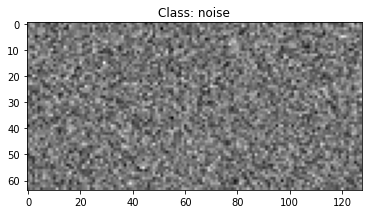

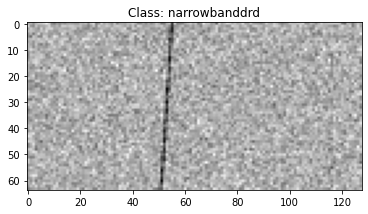

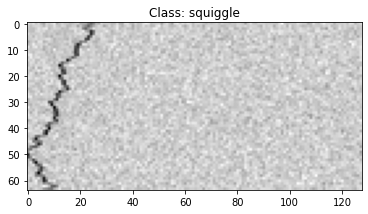

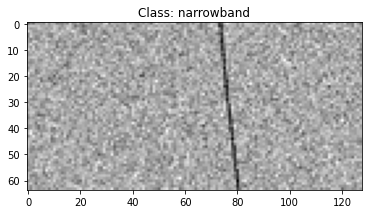

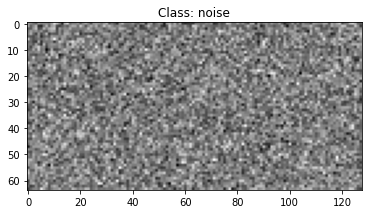

In [15]:
idx = np.random.randint(0, len(x_train), 5)

for i in idx:
    img = x_train[i]
    plt.title(f"Class: {classes[np.argmax(y_train[i])]}")
    plt.imshow(img, cmap="gray")
    plt.show()

## Training and Validation Data Generator

In [16]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [17]:
# Create data generator
datagen_train = ImageDataGenerator(horizontal_flip=True, rotation_range=30, vertical_flip=True)
datagen_val = ImageDataGenerator(horizontal_flip=True, rotation_range=30, vertical_flip=True)

In [18]:
# Fit datagenerator to dataset
datagen_train.fit(x_train)
datagen_val.fit(x_val)

## Model Definition

In [19]:
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Input, Dropout, Flatten, Conv2D
from tensorflow.keras.layers import BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import ModelCheckpoint

In [20]:
def build_sequential_model():
    model = Sequential([
        # Conv - BN - Pool layer
        Conv2D(32, (5,5), padding='same', input_shape=(64,128,1)),
        BatchNormalization(),
        Activation('relu'),
        MaxPooling2D(pool_size=(2,2)),
        Dropout(0.25),
        
        # Conv - BN - Pool layer
        Conv2D(64, (5,5), padding='same'),
        BatchNormalization(),
        Activation('relu'),
        MaxPooling2D(pool_size=(2,2)),
        Dropout(0.25),
        
        # Flatten Conv2d Outputs
        Flatten(),
        
        Dense(1024),
        BatchNormalization(),
        Activation('relu'),
        Dropout(0.4),
        
        # Output Layer
        Dense(4, activation='softmax')
    ])
    
    return model

In [21]:
def build_functional_model():
    input_layer = Input(shape=(64,128,1))
    
    x = Conv2D(32, (5,5), padding='same')(input_layer)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2,2))(x)
    x = Dropout(0.25)(x)
    
    x = Conv2D(64, (5,5), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2,2))(x)
    x = Dropout(0.25)(x)
    
    x = Flatten()(x)
    
    x = Dense(1064)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.25)(x)
    
    out = Dense(4, activation='softmax')(x)
    
    model = Model(inputs=input_layer, outputs=out)
    
    return model

## LR Scheduler and Model Compilation

In [22]:
# Initial Learning Rate
initial_lr = 0.005

# Learning rate scheduler
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=initial_lr,
    decay_steps=5,
    decay_rate=0.96,
    staircase=True
)

# Model Optimizer
optimizer = Adam(learning_rate=lr_schedule)

In [23]:
model = build_sequential_model()
model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])

2021-09-03 20:12:51.808332: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [24]:
# Model Summary
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 128, 32)       832       
_________________________________________________________________
batch_normalization (BatchNo (None, 64, 128, 32)       128       
_________________________________________________________________
activation (Activation)      (None, 64, 128, 32)       0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 64, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 32, 64, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 64, 64)        51264     
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 64, 64)        2

## Train the Model

In [25]:
# Model checkpoint callback
checkpoint = ModelCheckpoint('model_weight.h5', monitor='val_loss', save_weights_only=True, mode='min', verbose=0)

In [26]:
epochs = 30
batch_size = 32

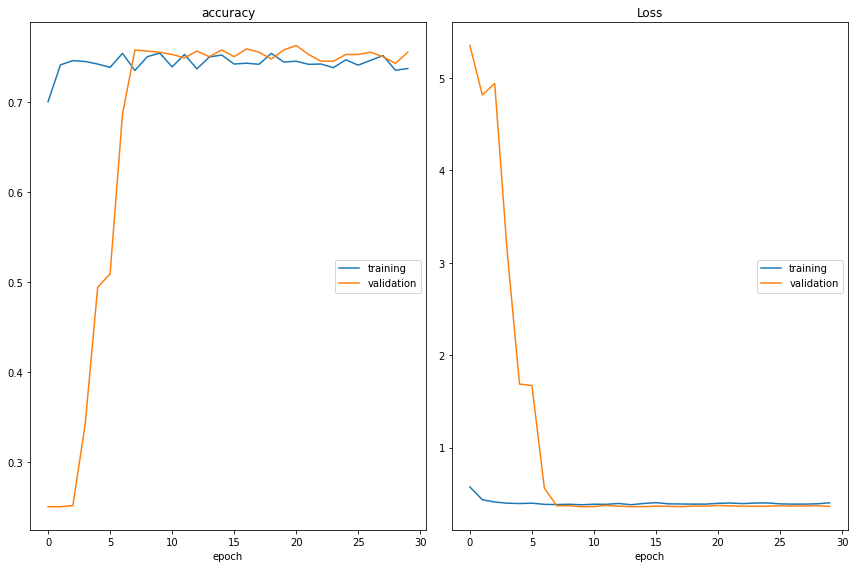

accuracy
	training         	 (min:    0.700, max:    0.754, cur:    0.737)
	validation       	 (min:    0.250, max:    0.762, cur:    0.755)
Loss
	training         	 (min:    0.382, max:    0.574, cur:    0.403)
	validation       	 (min:    0.360, max:    5.351, cur:    0.363)


In [27]:
history = model.fit(datagen_train.flow(x_train, y_train, batch_size=batch_size, shuffle=True),
                    steps_per_epoch = len(x_train) // batch_size,
                    validation_data = datagen_val.flow(x_val, y_val, batch_size=batch_size, shuffle=True),
                    validation_steps = len(x_val) // batch_size,
                    epochs=epochs,
                    callbacks=[PlotLossesCallback(), checkpoint]
                   )

## Trained Model Evaluation

In [28]:
model.evaluate(x_val, y_val)

25/25 [==============================] - 2s 65ms/step - loss: 0.5162 - accuracy: 0.7237


[0.5162392854690552, 0.7237499952316284]

In [32]:
import seaborn as sns
from sklearn import metrics

In [33]:
y_true = np.argmax(y_val, axis=1)
y_pred = np.argmax(model.predict(x_val), axis=1)

In [34]:
print(metrics.classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.81      1.00      0.89       200
           1       0.51      0.77      0.61       200
           2       0.52      0.13      0.21       200
           3       1.00      1.00      1.00       200

    accuracy                           0.72       800
   macro avg       0.71      0.72      0.68       800
weighted avg       0.71      0.72      0.68       800



In [35]:
# Classification Accuracy
print("Classification Accuracy: %0.6f" % metrics.accuracy_score(y_true, y_pred))

Classification Accuracy: 0.723750


<AxesSubplot:>

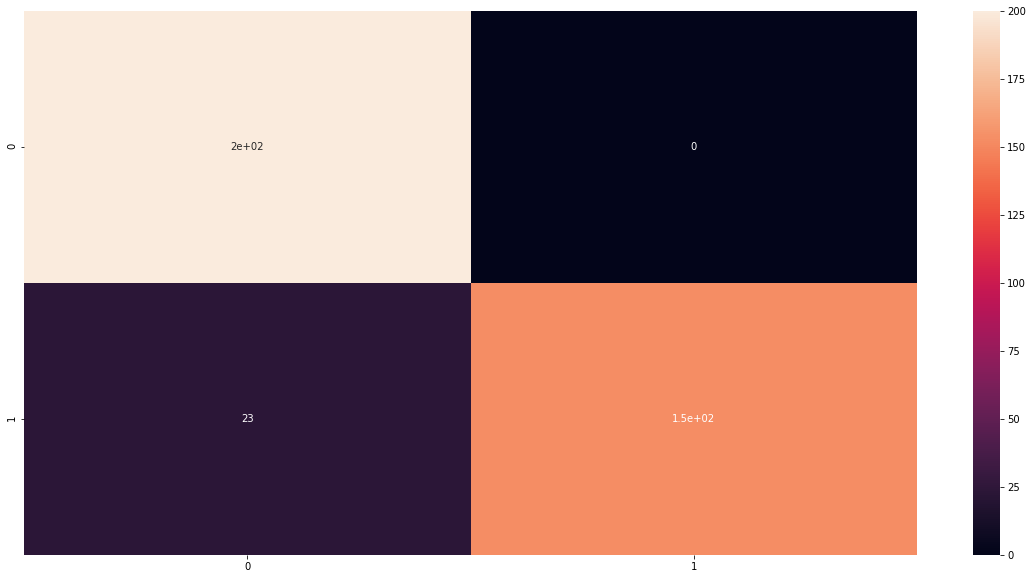

In [38]:
# Plot Confusion Matrix
conf_mat = confusion_matrix(y_true, y_pred, labels=[0, 1])
plt.figure(figsize=(20,10))
sns.heatmap(conf_mat, annot=True)